# Application of pyKAN for 1D VLBI Data Interpolation

## Introduction

Introduction goes here.

## Imports

In [39]:
import torch
import numpy as np
import pandas as pd

from kan import KAN
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings


## Precoded Functions

In [ ]:
def cross_section(dataset, delta, alpha_deg, length=None):
    alpha = np.radians(alpha_deg)   
    distance = np.abs(dataset['U'] * np.sin(alpha) - dataset['V'] * np.cos(alpha))
    mask_distance = distance <= delta
    
    if length is not None:
        projection = dataset['U'] * np.cos(alpha) + dataset['V'] * np.sin(alpha)
        mask_length = np.abs(projection) <= length
        mask = mask_distance & mask_length
    else:
        mask = mask_distance
    
    filtered_data = dataset[mask].copy()
    
    print(f"Angle: {alpha_deg}, (deg.)")
    print(f"Cross-section width: {delta}")
    print(f"Number of points: {mask.sum()}/{len(dataset)} ({mask.sum()/len(dataset)*100:.1f}%)")
    
    return filtered_data, mask, distance

## Globals and Settings

In [40]:
DATASET_FILE = '.\data\Cres_05.txt'

In [41]:
# random seed global variable
RANDOM_STATE = 42

In [42]:
# ignore warnings
warnings.filterwarnings(action="ignore")

In [ ]:
# initialize torch device as `gpu` if exists else `cpu`
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using `{device}` device for torch.")

# Data Loading

In [43]:
# load data from text file indicated in DATASET_FILE global variable
dataset = pd.read_csv(DATASET_FILE, sep='\t')

In [44]:
# general information about dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   U       259200 non-null  float64
 1   V       259200 non-null  float64
 2   Re      259200 non-null  float64
 3   Im      259200 non-null  float64
dtypes: float64(4)
memory usage: 7.9 MB


## EDA

In [45]:
dataset['Baseline'] = np.sqrt(dataset['U']**2 + dataset['V']**2)
dataset['Amplitude'] = np.sqrt(dataset['Re']**2 + dataset['Im']**2)

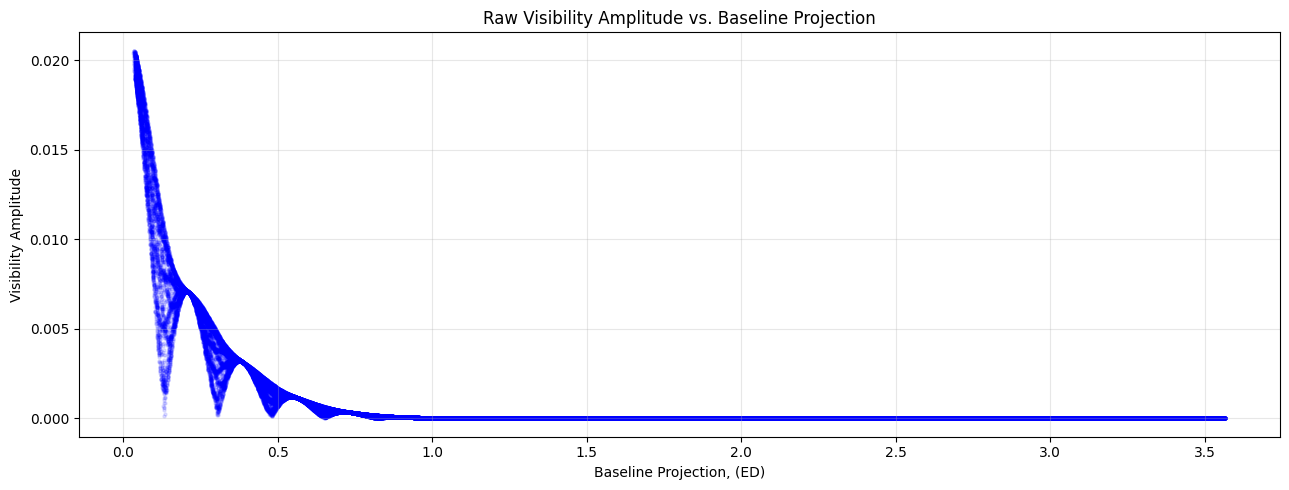

In [58]:
plt.figure(figsize=(13, 5))
plt.scatter(dataset['Baseline'], 
            dataset['Amplitude'], 
            alpha=0.1, 
            s=5,
            c='blue')
plt.xlabel('Baseline Projection, (ED)')
plt.ylabel('Visibility Amplitude')
plt.title('Raw Visibility Amplitude vs. Baseline Projection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
# extract visibility amplitude along the cross-section
delta_test = 0.01
alpha_test = 0

filtered_data, mask, distance = cross_section(dataset, 
                                              delta=delta_test, 
                                              alpha_deg=alpha_test)

Угол: 0°
Толщина сечения: 2×0.01
Расстояния до линии: min=0.00, max=3.24
Точек в сечении: 1606/259200 (0.6%)


## Model Initialization

In [ ]:
# initialize model
model = KAN(width=[6, 1, 1], 
            grid=3, 
            k=3, 
            seed=RANDOM_STATE, 
            device=device)

# Training

# Model Testing